# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense,ZeroPadding2D,Concatenate
#from keras.layers import merge
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from PIL import Image
from matplotlib import pylab as plt
import numpy as np
import math
import cv2
import skimage
from skimage import exposure
import numpy as np
import sys
import random
import warnings

In [ ]:
#Import MY Loss, SoftMax, Class weight Functions
from ASoftMax import my_forward
from ALoss import MyLoss
from AClass_Weight import create_class_weight

# Load Data

In [ ]:
num_classes = 7
img_rows, img_cols = 100,100
batch_size = 32

train_data_dir = '/raf_data/train'
validation_data_dir ='/raf_data/validation'

train_datagen = ImageDataGenerator(
       rescale=1./512,
      #rotation_range=20,
      #shear_range=0.2,
      #zoom_range=0.2,
      )

validation_datagen = ImageDataGenerator(rescale=1./512)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        class_mode='categorical',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        class_mode='categorical',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=True)


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


# MODEL 1

In [ ]:

l2=tf.keras.regularizers.l2(1e-3)
l1l2=regularizers.l1_l2(l1=1e-5, l2=1e-4)
l1=tf.keras.regularizers.l1(1e-4)
kernel_init = tf.keras.initializers.he_normal()
l2=regularizers.l2(0.01)
bias_init = tf.keras.initializers.Constant(value=0.1)

In [ ]:
def module1(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc1')

    return output

In [ ]:
def module2(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc2')

    return output

In [ ]:
model = Sequential()
input_layer = Input(shape=(img_rows, img_cols, 1))

input_half_1 = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(input_layer)

x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_101')(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization()(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_1')(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_102')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_103')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)

x0=AveragePooling2D(pool_size=(2, 2))(x)

y1=AveragePooling2D(pool_size=(4, 4))(x)

x1= concatenate([x0, input_half_1])
##############################################
i0=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal")(x1)

i1 = module1(i0,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc1')

i2 =module2(i1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc2')
i4 = AveragePooling2D(pool_size=(5, 5), padding='same', strides=None, name='max_pool_inception_01')(i2)
##############################################
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_201')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_2')(x1)
x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_202')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_203')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)

x2= AveragePooling2D(pool_size=(2, 2))(x1)

y2=AveragePooling2D(pool_size=(2, 2))(x2)

x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_301')(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_301')(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_302')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_303')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3_1=AveragePooling2D(pool_size=(2, 2)) (x3)

x4_1=concatenate([x3_1,y2])

x4=ZeroPadding2D((1, 1))(x4_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_401')(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)
x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_4')(x4)
x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv2d_402')(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)
x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None)(x6)


dc_1_0 = Conv2DTranspose(512, (4, 4), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_01')(x7)

dc_1_0=concatenate([i4,dc_1_0])
dc_1 = UpSampling2D((2,2))(dc_1_0)
dc_2_0 = Conv2DTranspose(256, (3, 3),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_02')(dc_1)
dc_2 = UpSampling2D((2,2))(dc_2_0)


x7_0 = Flatten()(dc_2)
x7_1 = Dense(1024, activation='elu',name='dense1')(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.0)(x7_2)
x7_4 = Dense(512, activation='elu',name='dense2_')(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.0)(x7_5)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x8 =Activation(my_forward,dynamic=True, name='SpecialActivation')(x8_1)

model1 = Model(input_layer, [x8], name='model1')

# MODEL 2

In [ ]:
def module1(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc1')

    return output

In [ ]:
def module2(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='inc1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='inc2')

    return output

In [ ]:
model = Sequential()
input_layer = Input(shape=(img_rows, img_cols, 1))

input_half_1 = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(input_layer)

x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_101')(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization()(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_1')(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_102')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv2d_103')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)

x0=AveragePooling2D(pool_size=(2, 2))(x)

y1=AveragePooling2D(pool_size=(4, 4))(x)

x1= concatenate([x0, input_half_1])
##############################################
i0=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal")(x1)

i1 = module1(i0,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc1')
i2 = module2(i1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc2')

i4 = AveragePooling2D(pool_size=(5, 5), padding='same', strides=None, name='max_pool_inception_01')(i2)
##############################################
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_201')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_2')(x1)
x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_202')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_203')(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)
x2= AveragePooling2D(pool_size=(2, 2))(x1)

y2=AveragePooling2D(pool_size=(2, 2))(x2)

x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_301')(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_301')(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_302')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_303')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3_1=AveragePooling2D(pool_size=(2, 2)) (x3)


x4_1=concatenate([x3_1,y2])


x4=ZeroPadding2D((1, 1))(x4_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv2d_401')(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)
x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv1d_4')(x4)
x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv2d_402')(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)
x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None)(x6)


dc_1_0 = Conv2DTranspose(512, (4, 4), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_01')(x7)
dc_1_0=concatenate([i4,dc_1_0])
dc_1 = UpSampling2D((2,2))(dc_1_0)


dc_2_0 = Conv2DTranspose(256, (3, 3),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_02')(dc_1)
dc_2 = UpSampling2D((2,2))(dc_2_0)


x7_0 = Flatten()(dc_2)
x7_1 = Dense(512, activation='elu',name='dense1_')(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.0)(x7_2)
x7_4 = Dense(256, activation='elu',name='dense2')(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.0)(x7_5)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x8 =Activation(my_forward,dynamic=True, name='SpecialActivation')(x8_1)

model2 = Model(input_layer, [x8], name='model2')

# MAIN MODEL

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

In [ ]:
models = [model1, model2]
model_input = tf.keras.Input(shape=(100,100,1))
model_outputs = [model(model_input) for model in models]
ensemble_average = WeightedAverageLayer(0.8, 0.2)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=[ensemble_average,model_outputs])

# Functions


In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def decay(epoch, steps=50):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+(2*epoch)/epochs_drop)))
    return lrate

checkpoint = ModelCheckpoint("raf_weights.h5",
                             #save the best model while all epovhs of training
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 0,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.96,
                              patience=4, min_lr=1e-6, verbose=1)

lr_sc = LearningRateScheduler(decay,verbose=0)

mycallback = [earlystop
              #,checkpoint
              ,reduce_lr
              ,lr_sc
              ,create_tensorboard_callback(dir_name="tensorflow_hub",
              experiment_name="mod2")]


#Load Weights
[link text](https://drive.google.com/file/d/1--VJOYHFxGMItbBmVXlqToB6RWpfMOrm/view?usp=sharing)

In [ ]:
model1.load_weights("raf_ensemble_0_1_0.h5",by_name=True)
model2.load_weights("raf_ensemble_0_1_0.h5",by_name=True)

# Training our model

In [ ]:
loss=MyLoss()
class_weights = create_class_weight(labels_dict)
lossWeights = {'out1': 0.8,'out2':0.2,'weighted_average_layer':2.0}


ensemble_model.compile(
              loss={'out1': loss,'out2':loss,'weighted_average_layer':loss },
              optimizer = Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics = ['accuracy'])

nb_train_samples = 12271
nb_validation_samples = 3068
epochs =70
batch_size=32


history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs = epochs,
    callbacks = mycallback,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    class_weight=class_weights,
    workers=8)

Saving TensorBoard log files to: tensorflow_hub/mod2/20230619-023115
Epoch 1/70


127/127 [==============================] - 93s 531ms/step - loss: 4.3709 - weighted_average_layer_loss: 0.8406 - model1_loss: 0.7366 - model2_loss: 1.8518 - weighted_average_layer_accuracy: 0.7520 - model1_accuracy: 0.7835 - model2_accuracy: 0.3701 - val_loss: 1.3174 - val_weighted_average_layer_loss: 0.0990 - val_model1_loss: 0.0985 - val_model2_loss: 0.1781 - val_weighted_average_layer_accuracy: 0.5000 - val_model1_accuracy: 0.5484 - val_model2_accuracy: 0.1290 - lr: 5.0000e-05
Epoch 2/70
127/127 [==============================] - 63s 497ms/step - loss: 3.4852 - weighted_average_layer_loss: 0.7198 - model1_loss: 0.6799 - model2_loss: 1.1438 - weighted_average_layer_accuracy: 0.8031 - model1_accuracy: 0.8307 - model2_accuracy: 0.5039 - val_loss: 1.2712 - val_weighted_average_layer_loss: 0.0768 - val_model1_loss: 0.0688 - val_model2_loss: 0.1838 - val_weighted_average_layer_accuracy: 0.7742 - val_model1_accuracy: 0.8065 - val_model2_accuracy: 0.0484 - lr: 5.0000e-05
Epoch 3/70
127/127 

# Ploting our Loss and Accuracy Charts

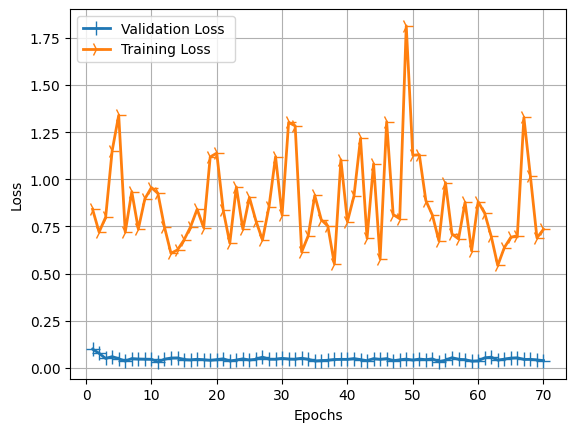

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['weighted_average_layer_loss']
val_loss_values = history_dict['val_weighted_average_layer_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss ')
line2 = plt.plot(epochs, loss_values, label='Training Loss ')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

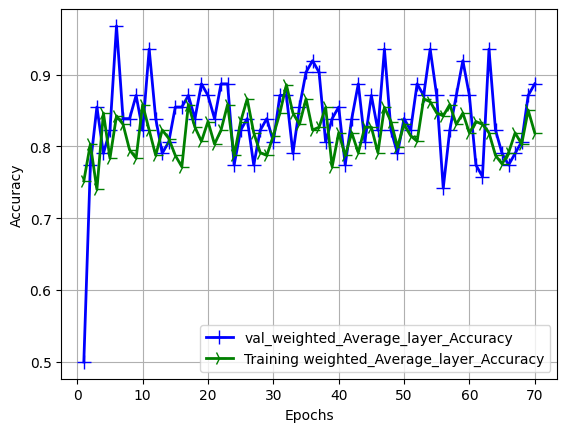

[0.5, 0.774193525314331, 0.8548387289047241, 0.7903226017951965, 0.8225806355476379, 0.9677419066429138, 0.8387096524238586, 0.8387096524238586, 0.8709677457809448, 0.8225806355476379, 0.9354838728904724, 0.8387096524238586, 0.7903226017951965, 0.8064516186714172, 0.8548387289047241, 0.8548387289047241, 0.8709677457809448, 0.8387096524238586, 0.8870967626571655, 0.8709677457809448, 0.8387096524238586, 0.8870967626571655, 0.8870967626571655, 0.774193525314331, 0.8225806355476379, 0.8387096524238586, 0.774193525314331, 0.8225806355476379, 0.8387096524238586, 0.8064516186714172, 0.8709677457809448, 0.8709677457809448, 0.7903226017951965, 0.8548387289047241, 0.9032257795333862, 0.9193548560142517, 0.9032257795333862, 0.8064516186714172, 0.8387096524238586, 0.8548387289047241, 0.774193525314331, 0.8387096524238586, 0.8870967626571655, 0.8064516186714172, 0.8709677457809448, 0.8225806355476379, 0.9354838728904724, 0.8225806355476379, 0.7903226017951965, 0.8387096524238586, 0.8225806355476379

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['weighted_average_layer_accuracy']
val_acc_values = history_dict['val_weighted_average_layer_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, color='b',label='val_weighted_Average_layer_Accuracy')
line2 = plt.plot(epochs, acc_values,color='g', label='Training weighted_Average_layer_Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
print (val_acc_values)

In [ ]:
acc = history.history['weighted_average_layer_accuracy']
val_acc = history.history['val_weighted_average_layer_accuracy']
loss = history.history['weighted_average_layer_loss']
val_loss = history.history['val_weighted_average_layer_loss']

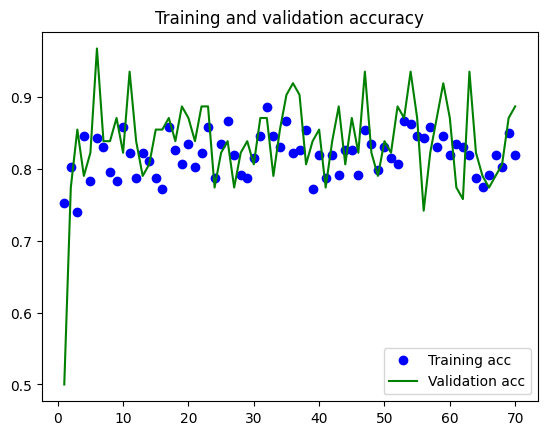

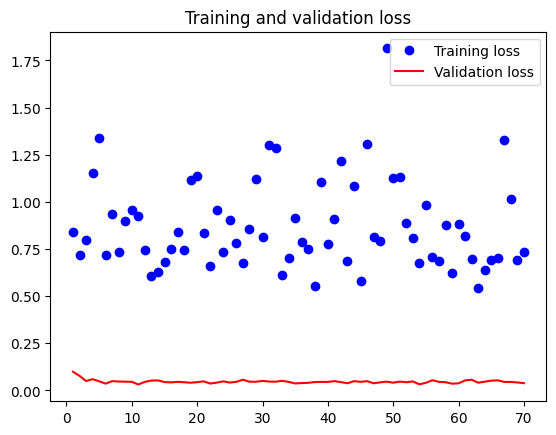

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

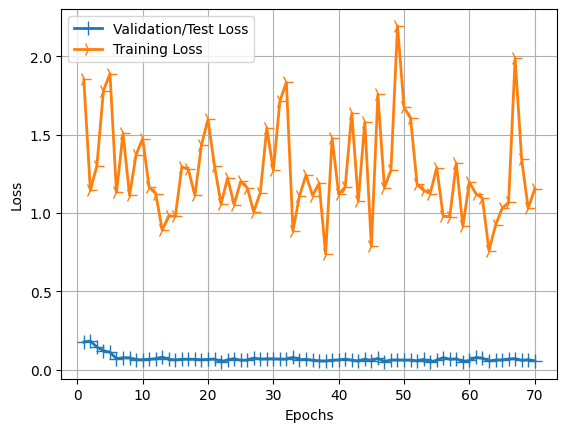

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['model2_loss']
val_loss_values = history_dict['val_model2_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

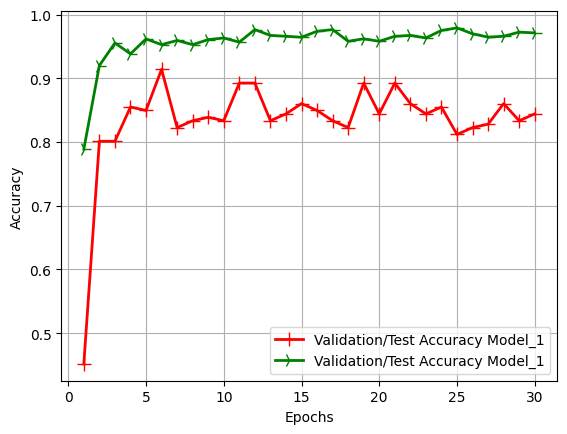

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['model2_accuracy']
val_acc_values = history_dict['val_model2_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, color='r',label='Validation/Test Accuracy Model_1')
line2 = plt.plot(epochs, acc_values,color='g', label='Validation/Test Accuracy Model_1')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()